# [Web3 Phishing Scammer Detection Competition](https://www.kaggle.com/competitions/forta-protect-web3) Benchmark Model: EasyEnsemble with One-Order Neighbors' Features

Features and model set-up were inspired by Chen, Weili, et al. “Phishing Scam Detection on Ethereum: Towards Financial Security for Blockchain Ecosystem.”

Proceedings of the Twenty-Ninth International Joint Conference on Artificial Intelligence, 2020, https://doi.org/10.24963/ijcai.2020/621.

In [3]:
from psutil import cpu_count
import os

import dask.dataframe as dd
from dask.distributed import Client

import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.36 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34509,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.36 GiB
Comm: tcp://127.0.0.1:33633,Total threads: 1
Dashboard: http://127.0.0.1:45527/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:35417,


In [35]:
# Get transaction data
data_dir = '../input/forta-protect-web3'


TX_DTYPES = {'value': 'object'}
COLUMNS = ['nonce', 'to_address', 'from_address', 'value', 'block_number', 'gas', 'gas_price', 'max_fee_per_gas', 'max_priority_fee_per_gas', 'transaction_type']

train_dfs = dd.read_csv(f'{data_dir}/eoa_tx_train/eoa_tx_train/*.csv', dtype=TX_DTYPES, usecols=COLUMNS)
test_dfs = dd.read_csv(f'{data_dir}/eoa_tx_test/eoa_tx_test/*.csv', dtype=TX_DTYPES, usecols=COLUMNS)

In [36]:
# Get training ground truth values and ids
train_ids = pd.read_csv(f'{data_dir}/train.csv')
test_ids = pd.read_csv(f'{data_dir}/test.csv')

In [25]:
train_dfs.head(5)

,nonce,from_address,to_address,value,gas,gas_price,block_number,max_fee_per_gas,max_priority_fee_per_gas,transaction_type
0,4887,0xf0d6b27e70bca818fc22a8abe30148191a5ed350,0xd633f20dedd2170221e47a80ca92385291bf0a73,860000000000000000,196608,10000000000,9086330,NaN,NaN,NaN
1,4,0xf32be55bf829de1d43bc79d3639adc5353697003,NaN,0,6553600,25000000000,11127902,NaN,NaN,NaN
2,3,0x89f4243acf4b931f5ffd5db5d0e9d3258c1647d1,0xb76c291871b92a7c9e020b2511a3402a3bf0499d,124648999884413117,459008,24000000000,12608382,NaN,NaN,NaN
3,226,0xfc673be13c7c3cceab6b7db080b4b79698b1253a,0xb64ef51c888972c908cfacf59b47c1afbc0ab8ac,0,66816,22000000000,10086538,NaN,NaN,NaN
4,120,0xc730aafd39866a2eab5a35e413f3a38f968f4f8e,0xb64ef51c888972c908cfacf59b47c1afbc0ab8ac,0,66816,25000000000,10099946,NaN,NaN,NaN


In [7]:
train_dfs.describe()

,nonce,gas,gas_price,block_number,max_fee_per_gas,max_priority_fee_per_gas,transaction_type
npartitions=1,,,,,,,
,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...


In [37]:
first_tx_train = pd.to_datetime(train_ids['first_tx_timestamp'])
last_tx_train = pd.to_datetime(train_ids['last_tx_timestamp'])
account_age_train = last_tx_train - first_tx_train
first_tx_test = pd.to_datetime(test_ids['first_tx_timestamp'])
last_tx_test = pd.to_datetime(test_ids['last_tx_timestamp'])
account_age_test = last_tx_test - first_tx_test

In [38]:
# add account age to training ground truth set
train_ids['account_age']=account_age_train.astype('timedelta64[D]')
test_ids['account_age']=account_age_test.astype('timedelta64[D]')

Convert account age to days

In [39]:
train_ids.head(5)

,address,target,first_tx_timestamp,last_tx_timestamp,account_age
0,0x6dba043ee0b1dad1a3b48be75bf28dd4b45fe3a3,1,2020-10-11 21:05:38 UTC,2020-10-12 13:21:27 UTC,0.0
1,0x878cce43a3b9d8a872a33d2d6ccd561e033707f4,1,2018-02-28 14:52:49 UTC,2018-02-28 21:46:12 UTC,0.0
2,0xf033f0d9c1bf050babe586fddd94d8928f02ac50,1,2018-04-19 23:55:45 UTC,2018-12-16 17:15:31 UTC,240.0
3,0x6c20ef21e604028c649247c581e8e49fda6191ca,1,2018-03-31 04:57:10 UTC,2018-07-05 01:40:27 UTC,95.0
4,0xab486933bc2e24580080b9e97c2abcd493c0a136,1,2018-07-12 06:54:48 UTC,2018-07-19 09:57:58 UTC,7.0


In [40]:
test_ids.head(5)

,address,first_tx_timestamp,last_tx_timestamp,Id,account_age
0,0x8808273c346152c4df2ce49a3299079c87215298,2021-09-01 06:27:20 UTC,2022-05-26 00:38:09 UTC,1,266.0
1,0xec203218855498cb08d47ec6f585c9c263d2663c,2021-04-25 13:53:18 UTC,2022-03-10 11:54:40 UTC,2,318.0
2,0x849c93a693d2c1e81daa40723199ece968cce590,2022-02-02 04:55:54 UTC,2022-02-14 23:50:36 UTC,3,12.0
3,0x5586e22d0c78735e769c25a56ef46116ccac37e5,2022-04-30 16:45:01 UTC,2022-05-12 09:11:34 UTC,4,11.0
4,0x678155075c95608d60b472e77a4616bb91371156,2022-02-23 05:34:06 UTC,2022-06-03 18:31:34 UTC,5,100.0


In [12]:
train_ids['account_age'].describe()

count    737093.000000
mean        162.564174
std         282.074092
min           0.000000
25%           0.000000
50%          35.000000
75%         192.000000
max        2292.000000
Name: account_age, dtype: float64

Create visualization to explore extent to which account_age may contribute to EOA phisher status.

<AxesSubplot:xlabel='account_age', ylabel='Count'>

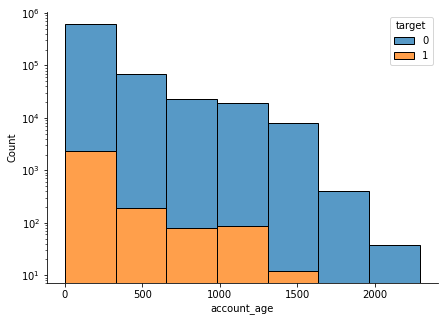

In [13]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    train_ids,
    x="account_age", hue="target",
    bins=7,
    multiple="stack",
    log_scale=(False,True),
)

It doesn't look like the account age is concentrated at any particular range enough to make a significant difference in the classification. Let's confirm that by building a Logistic Regression model.

In [14]:
X = train_ids['account_age']
y = train_ids['target']
X = X.values
X = X.reshape(-1,1)
print(X.shape)
print(X.dtype)
print(y.shape)

(737093, 1)
float64
(737093,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')  #balanced to account for the large class imbalance
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [31]:
from sklearn.model_selection import cross_val_score

cross_val_score(log_reg, X_train, y_train, cv=3, scoring="accuracy")

array([0.29279927, 0.28887032, 0.29120381])

Indeed, the accuracy of this model is quite low. Let's keep this feature and continue building out a robust model with many more features.

In [41]:
def generate_features(tx_df, labels):
    # Convert value from WEI to ETH and gas prices to GWEI
    tx_df['value_eth'] = tx_df['value'].str.zfill(18).astype(float) / 1e18
    tx_df['gas_price_gwei'] = tx_df['gas_price'] / 1e9
    tx_df['max_fee_per_gas_gwei'] = tx_df['max_fee_per_gas'] / 1e9
    tx_df['max_priority_fee_per_gas_gwei'] = tx_df['max_priority_fee_per_gas'] / 1e9
    incoming = tx_df.merge(labels, how='left', left_on='to_address', right_on='address')
    incoming = incoming[incoming['address'].notnull()].compute()
    
    incoming_agg = incoming.groupby('to_address').agg({'block_number': 'std', 
                                                       'from_address': ['count', 'nunique'],
                                                       'value_eth': ['max', 'mean', 'min', 'sum']}).reset_index()
    incoming_agg.columns = ["_".join(filter(None, name)) for name in incoming_agg.columns.to_flat_index()]
    # in_block_number_std: standard deviation of blockNumber of all incoming transactions for an EOA
    # in_value_max: maximum value of all incoming transactions for an EOA
    # in_value_mean: mean value of all incoming transactions for an EOA
    # in_value_min: minimum value of all incoming transactions for an EOA
    # in_value_sum: sum of all incoming transactions for an EOA
    # from_address_count: total incoming transaction count for an EOA
    # from_address_nunique: total incoming transaction from unique address for an EOA
    incoming_agg = incoming_agg.rename(columns={'block_number_std': 'in_block_number_std',
                                                'value_eth_max': 'in_value_max',
                                                'value_eth_mean': 'in_value_mean',
                                                'value_eth_min': 'in_value_min',
                                                'value_eth_sum': 'in_value_sum'})
    # from_address_count_unique_ratio: of all incoming transactions, what ratio is unique?
    incoming_agg['from_address_count_unique_ratio'] = incoming_agg['from_address_nunique'] / incoming_agg['from_address_count']
    # for std with 1 transaction, fill na with 0
    # https://stackoverflow.com/questions/32130954/pandas-standard-deviation-returns-nan
    incoming_agg['in_block_number_std'] = incoming_agg['in_block_number_std'].fillna(0)
    incoming_2 = incoming.merge(incoming_agg, how='left', left_on='to_address', right_on='to_address')
    incoming_2['transaction_type'] = incoming_2['transaction_type'].fillna(3)
    incoming_2 = incoming_2.drop(['value', 'gas_price', 'max_fee_per_gas', 'max_priority_fee_per_gas', 'from_address', 'first_tx_timestamp', 'last_tx_timestamp', 'address', 'target', 'account_age'], axis=1)
    dt = labels.merge(incoming_2, how='left', left_on='address', right_on='to_address')
    dt = dt.drop(['to_address', 'first_tx_timestamp', 'last_tx_timestamp'], axis=1)
    dt = dt.fillna(0)
    
    return dt

In [42]:
train_data = generate_features(train_dfs, train_ids)

In [43]:
train_data

,address,target,account_age,nonce,gas,block_number,transaction_type,value_eth,gas_price_gwei,max_fee_per_gas_gwei,max_priority_fee_per_gas_gwei,in_block_number_std,from_address_count,from_address_nunique,in_value_max,in_value_mean,in_value_min,in_value_sum,from_address_count_unique_ratio
0,0x6dba043ee0b1dad1a3b48be75bf28dd4b45fe3a3,1,0.0,2992662,21000,11037640,3.0,6.000000,60.0,0.0,0.0,388.474550,7,5,10.095000,3.136875,0.001343,21.958123,0.714286
1,0x6dba043ee0b1dad1a3b48be75bf28dd4b45fe3a3,1,0.0,741848,200000,11036892,3.0,0.525963,27.0,0.0,0.0,388.474550,7,5,10.095000,3.136875,0.001343,21.958123,0.714286
2,0x6dba043ee0b1dad1a3b48be75bf28dd4b45fe3a3,1,0.0,74,21000,11036923,3.0,0.001343,32.0,0.0,0.0,388.474550,7,5,10.095000,3.136875,0.001343,21.958123,0.714286
3,0x6dba043ee0b1dad1a3b48be75bf28dd4b45fe3a3,1,0.0,22,21000,11036584,3.0,5.000000,32.0,0.0,0.0,388.474550,7,5,10.095000,3.136875,0.001343,21.958123,0.714286
4,0x6dba043ee0b1dad1a3b48be75bf28dd4b45fe3a3,1,0.0,741823,200000,11036837,3.0,10.095000,28.0,0.0,0.0,388.474550,7,5,10.095000,3.136875,0.001343,21.958123,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5378269,0xf2ce4383ae5f184dcdf53e6d105a683e5bd3ca90,0,76.0,394,21000,7519598,3.0,0.000916,4.0,0.0,0.0,1192.182033,2,1,0.000977,0.000946,0.000916,0.001893,0.500000
5378270,0x65cdc618c579aceb6d024a3ec8e0f786f4d7c83b,0,0.0,26671,21000,6041300,3.0,0.000597,3.0,0.0,0.0,0.000000,2,1,0.000597,0.000597,0.000597,0.001195,0.500000
5378271,0x65cdc618c579aceb6d024a3ec8e0f786f4d7c83b,0,0.0,26672,21000,6041300,3.0,0.000597,3.0,0.0,0.0,0.000000,2,1,0.000597,0.000597,0.000597,0.001195,0.500000
5378272,0x0693fb4fa871d3900fa53fa3c03f6275706f2b3d,0,54.0,3,21000,10462194,3.0,0.015000,41.0,0.0,0.0,1152.584053,2,2,0.056942,0.035971,0.015000,0.071942,1.000000


In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5378274 entries, 0 to 5378273
Data columns (total 19 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   address                          object 
 1   target                           int64  
 2   account_age                      float64
 3   nonce                            int64  
 4   gas                              int64  
 5   block_number                     int64  
 6   transaction_type                 float64
 7   value_eth                        float64
 8   gas_price_gwei                   float64
 9   max_fee_per_gas_gwei             float64
 10  max_priority_fee_per_gas_gwei    float64
 11  in_block_number_std              float64
 12  from_address_count               int64  
 13  from_address_nunique             int64  
 14  in_value_max                     float64
 15  in_value_mean                    float64
 16  in_value_min                     float64
 17  in_value

In [45]:
train_data.describe()

,target,account_age,nonce,gas,block_number,transaction_type,value_eth,gas_price_gwei,max_fee_per_gas_gwei,max_priority_fee_per_gas_gwei,in_block_number_std,from_address_count,from_address_nunique,in_value_max,in_value_mean,in_value_min,in_value_sum,from_address_count_unique_ratio
count,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06,5.378274e+06
mean,2.101585e-02,4.100692e+02,1.998417e+06,6.852804e+04,7.945882e+06,2.973762e+00,2.128692e+01,4.675558e+01,5.051666e+00,2.603727e-01,5.276322e+05,1.067142e+03,6.586469e+02,1.908763e+02,2.128692e+01,6.639682e+00,2.530419e+04,4.588057e-01
std,1.434371e-01,4.457788e+02,5.356698e+06,1.691020e+05,3.175538e+06,1.648788e-01,2.878345e+02,2.470026e+02,4.291309e+01,6.638710e+00,6.761651e+05,4.353322e+03,3.441862e+03,1.607797e+03,2.007050e+02,7.657433e+01,4.690674e+05,3.841218e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+04,4.687900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.555584e-04
25%,0.000000e+00,4.600000e+01,5.000000e+00,2.100000e+04,5.040850e+06,3.000000e+00,2.015000e-02,7.500000e+00,0.000000e+00,0.000000e+00,4.807120e+04,4.000000e+00,2.000000e+00,1.649690e-01,5.362396e-02,1.176000e-03,1.113172e+00,5.263158e-02
50%,0.000000e+00,2.350000e+02,1.001300e+04,2.500000e+04,7.623054e+06,3.000000e+00,1.161461e-01,2.100000e+01,0.000000e+00,0.000000e+00,2.764138e+05,2.500000e+01,4.000000e+00,1.422557e+00,2.528178e-01,1.001178e-02,1.380456e+01,4.000000e-01
75%,0.000000e+00,6.470000e+02,7.214615e+05,7.475200e+04,1.076978e+07,3.000000e+00,1.000000e+00,5.300000e+01,0.000000e+00,0.000000e+00,7.360242e+05,1.960000e+02,1.000000e+01,1.500000e+01,1.823341e+00,6.500000e-02,1.010000e+02,8.823529e-01
max,1.000000e+00,2.292000e+03,3.992021e+07,1.184590e+07,1.401319e+07,3.000000e+00,1.800000e+05,2.786099e+05,4.415855e+03,2.944878e+03,8.816226e+06,3.347600e+04,3.273600e+04,1.800000e+05,9.005000e+04,1.791100e+04,1.136723e+07,1.000000e+00


In [47]:
os.remove("/kaggle/working/train_data.csv") #remove legacy train_data.csv file

In [48]:
train_data.to_csv('train_data.csv',index=False) #save file to disk

In [5]:
train_data = pd.read_csv("/kaggle/working/train_data.csv") #add train_data.csv file to workspace

Setup function to extract and prepare data for model training.

In [6]:
def get_features_and_labels(features, no_labels=False):
    EXCLUDE_COLS = {'target', 'address', 'Id'}
    x_cols = [col for col in features.columns if col not in EXCLUDE_COLS]

    X = features[x_cols] 
    y = None if no_labels else features['target']
    
    #convert to numpy arrays
    X = X.to_numpy() 
    y = y.to_numpy()
    
    return X, y

In [7]:
x_train, y_train = get_features_and_labels(train_data)

In [9]:
x_train.shape

(5378274, 17)

In [10]:
y_train.shape

(5378274,)

In [8]:
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.Normalization()
normalizer.adapt(x_train)
input_shape = x_train.shape[1:]

2022-11-07 02:34:57.792685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
EPOCHS = 20
BATCH_SIZE = 2048

In [46]:
# Create a model that includes the normalization layer
inputs = keras.Input(shape=input_shape)
x = normalizer(inputs)
y = layers.Dense(16, activation='relu')(x)
z = keras.layers.Dropout(0.5)(y)
outputs = layers.Dense(1, activation='sigmoid')(z)
model = keras.Model(inputs, outputs)

In [47]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
normalization_1 (Normalizati (None, 17)                35        
_________________________________________________________________
dense_12 (Dense)             (None, 16)                288       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 340
Trainable params: 305
Non-trainable params: 35
_________________________________________________________________


In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [49]:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True)

Epoch 1/20
2627/2627 [==============================] - 17s 6ms/step - loss: 0.1224 - tp: 6241.0000 - fp: 35544.0000 - tn: 5229701.0000 - fn: 106788.0000 - accuracy: 0.9735 - precision: 0.1494 - recall: 0.0552 - auc: 0.7443 - prc: 0.0655
Epoch 2/20
2627/2627 [==============================] - 16s 6ms/step - loss: 0.0794 - tp: 12262.0000 - fp: 480.0000 - tn: 5264765.0000 - fn: 100767.0000 - accuracy: 0.9812 - precision: 0.9623 - recall: 0.1085 - auc: 0.8519 - prc: 0.2733
Epoch 3/20
2627/2627 [==============================] - 16s 6ms/step - loss: 0.0732 - tp: 12593.0000 - fp: 355.0000 - tn: 5264890.0000 - fn: 100436.0000 - accuracy: 0.9813 - precision: 0.9726 - recall: 0.1114 - auc: 0.8847 - prc: 0.3329
Epoch 4/20
2627/2627 [==============================] - 16s 6ms/step - loss: 0.0707 - tp: 12692.0000 - fp: 277.0000 - tn: 5264968.0000 - fn: 100337.0000 - accuracy: 0.9813 - precision: 0.9786 - recall: 0.1123 - auc: 0.9001 - prc: 0.3552
Epoch 5/20
2627/2627 [=============================

While the accuracy and precision may look nice, the recall is abysmal. This is likely due to the massive class imbalance between accounts identified as phishers (positive cases) and those that were not (negative cases). Let's examine this class imbalance.

In [13]:
neg, pos = np.bincount(train_data['target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 5378274
    Positive: 113029 (2.10% of total)



There are only 113,029 examples of phishing accounts in this corpus, or 2.10%. Let's set an accurate bias initialization to account for this imbalance per https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [14]:
initial_bias = np.log([pos/neg])

In [52]:
output_bias = tf.keras.initializers.Constant(initial_bias)

#make the model again with the bias in the output layer
inputs = keras.Input(shape=input_shape)
x = normalizer(inputs)
y = layers.Dense(16, activation='relu')(x)
z = keras.layers.Dropout(0.5)(y)
outputs = layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(z)
model = keras.Model(inputs, outputs)

In [53]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
normalization_1 (Normalizati (None, 17)                35        
_________________________________________________________________
dense_14 (Dense)             (None, 16)                288       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 340
Trainable params: 305
Non-trainable params: 35
_________________________________________________________________


Let's also weight the positive samples more heavily so the classifier pays more attention to this class.

In [15]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 23.79


In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
          shuffle=True, class_weight=class_weight)

Epoch 1/20
2627/2627 [==============================] - 37s 6ms/step - loss: 0.6582 - tp: 79720.0000 - fp: 999074.0000 - tn: 9531416.0000 - fn: 146338.0000 - accuracy: 0.8935 - precision: 0.0739 - recall: 0.3527 - auc: 0.8065 - prc: 0.1216
Epoch 2/20
2627/2627 [==============================] - 17s 6ms/step - loss: 0.4709 - tp: 83430.0000 - fp: 1067680.0000 - tn: 4197565.0000 - fn: 29599.0000 - accuracy: 0.7960 - precision: 0.0725 - recall: 0.7381 - auc: 0.8586 - prc: 0.1777
Epoch 3/20
2627/2627 [==============================] - 16s 6ms/step - loss: 0.4226 - tp: 94644.0000 - fp: 1176158.0000 - tn: 4089087.0000 - fn: 18385.0000 - accuracy: 0.7779 - precision: 0.0745 - recall: 0.8373 - auc: 0.8849 - prc: 0.2268
Epoch 4/20
2627/2627 [==============================] - 17s 7ms/step - loss: 0.4091 - tp: 99403.0000 - fp: 1255410.0000 - tn: 4009835.0000 - fn: 13626.0000 - accuracy: 0.7640 - precision: 0.0734 - recall: 0.8794 - auc: 0.8952 - prc: 0.2575
Epoch 5/20
2627/2627 [==================

Let's try with no bias in the model.

In [56]:
inputs = keras.Input(shape=input_shape)
x = normalizer(inputs)
y = layers.Dense(16, activation='relu')(x)
z = keras.layers.Dropout(0.5)(y)
outputs = layers.Dense(1, activation='sigmoid')(z)
model = keras.Model(inputs, outputs)

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
          shuffle=True, class_weight=class_weight)

Epoch 1/20
2627/2627 [==============================] - 18s 6ms/step - loss: 0.4912 - tp: 194639.0000 - fp: 2555964.0000 - tn: 7974526.0000 - fn: 31419.0000 - accuracy: 0.7595 - precision: 0.0708 - recall: 0.8610 - auc: 0.8903 - prc: 0.2268
Epoch 2/20
2627/2627 [==============================] - 16s 6ms/step - loss: 0.4141 - tp: 101725.0000 - fp: 1413980.0000 - tn: 3851265.0000 - fn: 11304.0000 - accuracy: 0.7350 - precision: 0.0671 - recall: 0.9000 - auc: 0.8931 - prc: 0.2717
Epoch 3/20
2627/2627 [==============================] - 17s 6ms/step - loss: 0.3908 - tp: 102387.0000 - fp: 1305095.0000 - tn: 3960150.0000 - fn: 10642.0000 - accuracy: 0.7554 - precision: 0.0727 - recall: 0.9058 - auc: 0.9070 - prc: 0.3079
Epoch 4/20
2627/2627 [==============================] - 16s 6ms/step - loss: 0.3804 - tp: 102706.0000 - fp: 1243791.0000 - tn: 4021454.0000 - fn: 10323.0000 - accuracy: 0.7668 - precision: 0.0763 - recall: 0.9087 - auc: 0.9138 - prc: 0.3235
Epoch 5/20
2627/2627 [==============

Let's try with no dropout and no bias; only the class weighting.

In [16]:
inputs = keras.Input(shape=input_shape)
x = normalizer(inputs)
y = layers.Dense(16, activation='relu')(x)
# z = keras.layers.Dropout(0.5)(y)
outputs = layers.Dense(1, activation='sigmoid')(y)
model = keras.Model(inputs, outputs)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
          shuffle=True, class_weight=class_weight)

Epoch 1/20
2627/2627 [==============================] - 19s 6ms/step - loss: 0.4190 - tp: 98200.0000 - fp: 1312626.0000 - tn: 3952619.0000 - fn: 14829.0000 - accuracy: 0.7532 - precision: 0.0696 - recall: 0.8688 - auc: 0.8870 - prc: 0.2474
Epoch 2/20
2627/2627 [==============================] - 16s 6ms/step - loss: 0.3240 - tp: 102145.0000 - fp: 972846.0000 - tn: 4292399.0000 - fn: 10884.0000 - accuracy: 0.8171 - precision: 0.0950 - recall: 0.9037 - auc: 0.9382 - prc: 0.4616
Epoch 3/20
2627/2627 [==============================] - 17s 6ms/step - loss: 0.2947 - tp: 102877.0000 - fp: 843664.0000 - tn: 4421581.0000 - fn: 10152.0000 - accuracy: 0.8412 - precision: 0.1087 - recall: 0.9102 - auc: 0.9505 - prc: 0.5213
Epoch 4/20
2627/2627 [==============================] - 17s 6ms/step - loss: 0.2797 - tp: 103316.0000 - fp: 754625.0000 - tn: 4510620.0000 - fn: 9713.0000 - accuracy: 0.8579 - precision: 0.1204 - recall: 0.9141 - auc: 0.9551 - prc: 0.5397
Epoch 5/20
2627/2627 [===================

## Areas of Improvement

1. Test with validation dataset
2. Save training history for different models and visualize differences
3. Try out different network architectures
4. Try out different combinations of class weights, biases, and learning rates
5. Try oversampling the positive cases and training on this data
6. Try adding features from other datasets
7. Remove EOA's from the data